In [93]:
# import required libraries
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling as pp
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.simplefilter("ignore")
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, f1_score, average_precision_score, auc, precision_recall_curve, log_loss
seed=123
import sys
import joblib

In [2]:
# read dataset
df1 = pd.read_csv("Tweets.csv")
df1.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# get info on dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
df1.shape

(14640, 15)

In [5]:
# drop unwanted columns
df2 = df1.drop(['tweet_id','name', 'retweet_count', 'tweet_coord', 'tweet_created',
                               'tweet_location','user_timezone'],axis = 1)

In [6]:
df2.shape

(14640, 8)

In [7]:
profile = pp.ProfileReport(df2)
profile.to_file("project2_output.html")

From profile report, we can see negativereason, negativereason_confidence, airline_sentiment_gold & negativereason_gold contains missing values. We will replace the missing values either with spaces or with zeros depending upon the type of the attribute.

# EDA

Text(0.5, 1.0, 'Tweet Count by Airline')

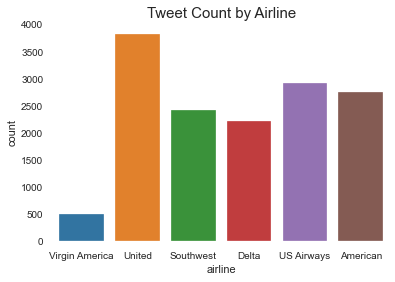

In [19]:
# Most tweeted airlines
sns.countplot(data=df2, x='airline')
plt.title('Tweet Count by Airline', fontsize=15)


Text(0.5, 1.0, 'Airline Sentiment Plot')

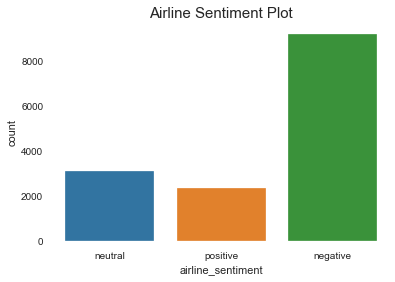

In [20]:
# plot showing the Airline Sentiment
sns.countplot(data=df2, x='airline_sentiment')
plt.title('Airline Sentiment Plot', fontsize=15)

Text(0.5, 1.0, 'Airline Sentiment Gold Plot')

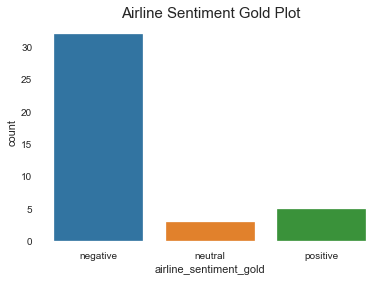

In [21]:
# plot showing the Airline Sentiment Gold
sns.countplot(data=df1, x='airline_sentiment_gold')
plt.title('Airline Sentiment Gold Plot', fontsize=15)

Text(0.5, 1.0, 'Sentiment Plot by Airlines')

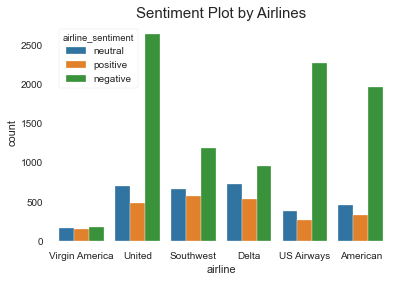

In [22]:
# plot sentiment per airline
sns.countplot(data=df1, x='airline', hue='airline_sentiment')
plt.title('Sentiment Plot by Airlines', fontsize=15)

Text(0.5, 1.0, 'Top Negative Reason Counts')

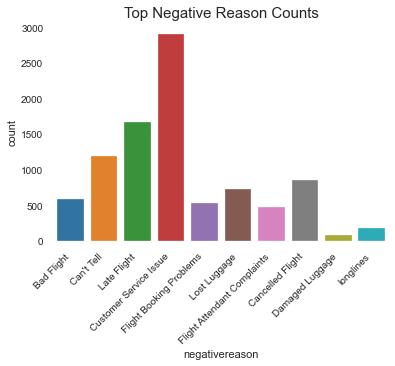

In [23]:
# plot showing the top Negative Reasons 
sns.countplot(data=df1, x='negativereason')
plt.xticks(rotation=45, horizontalalignment="right")
plt.title('Top Negative Reason Counts', fontsize=15)

# Data Cleaning

In [24]:
df2['negativereason'] = df2['negativereason'].fillna('')
df2['negativereason_confidence'] = df2['negativereason_confidence'].fillna(0)
df2['airline_sentiment_gold'] = df2['airline_sentiment_gold'].fillna('')
df2['negativereason_gold'] = df2['negativereason_gold'].fillna('')

In [25]:
df2.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,text
0,neutral,1.0000,,0.0000,Virgin America,,,@VirginAmerica What @dhepburn said.
1,positive,0.3486,,0.0000,Virgin America,,,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,,0.0000,Virgin America,,,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Bad Flight,0.7033,Virgin America,,,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Can't Tell,1.0000,Virgin America,,,@VirginAmerica and it's a really big bad thing...


In [26]:
# check for null values again
df2.isna().sum() 

airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
airline_sentiment_gold          0
negativereason_gold             0
text                            0
dtype: int64

In [27]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [34]:
from wordcloud import WordCloud, STOPWORDS
def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=100,background_color="black").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

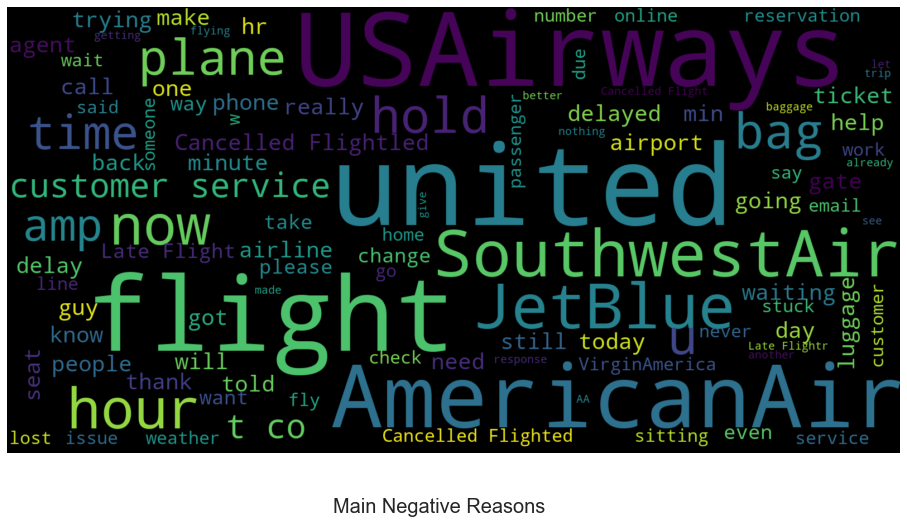

In [37]:
df3 = df2.loc[df2.airline_sentiment=='negative']
show_wordcloud(df3['text'], title = 'Main Negative Reasons')

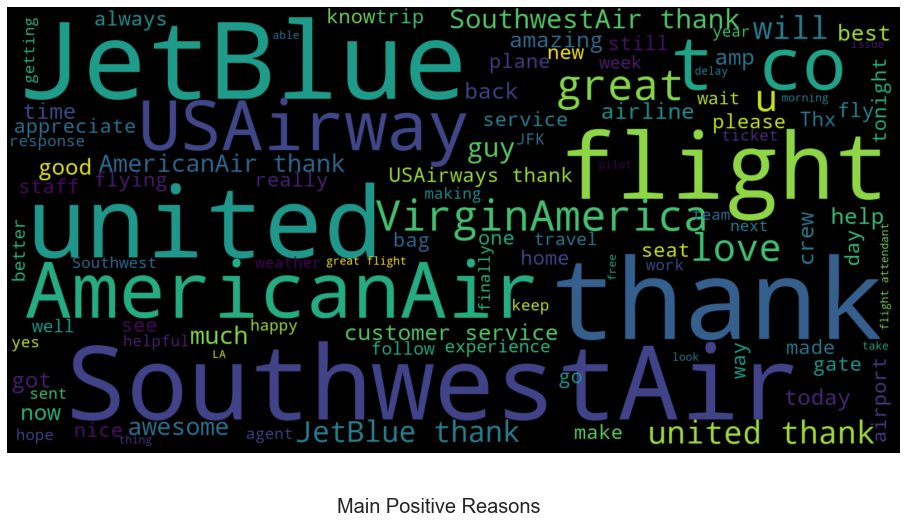

In [38]:
df4 = df2.loc[df2.airline_sentiment=='positive']
show_wordcloud(df4['text'], title = 'Main Positive Reasons')

# Sentiment Analysis

In [39]:
sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral" 

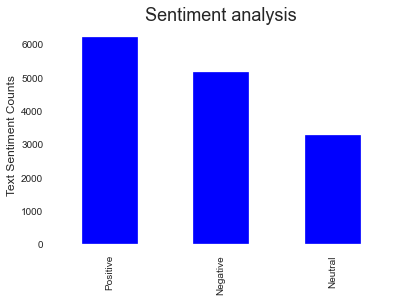

In [54]:
df2['sentiment'] = df2['text'].apply(lambda x: find_sentiment(x))

counts = df2['sentiment'].value_counts()
counts.plot(kind='bar', color='blue')
plt.ylabel('Text Sentiment Counts', size=12)
plt.title('Sentiment analysis', size=18)
plt.show()

# Data Transformation

In [55]:
df2['airline_sentiment'].replace(('neutral', 'positive', 'negative'), (0, 1, 2), inplace=True)
df2.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,text,sentiment
0,0,1.0000,,0.0000,Virgin America,,,@VirginAmerica What @dhepburn said.,Neutral
1,1,0.3486,,0.0000,Virgin America,,,@VirginAmerica plus you've added commercials t...,Neutral
2,0,0.6837,,0.0000,Virgin America,,,@VirginAmerica I didn't today... Must mean I n...,Neutral
3,2,1.0000,Bad Flight,0.7033,Virgin America,,,@VirginAmerica it's really aggressive to blast...,Negative
4,2,1.0000,Can't Tell,1.0000,Virgin America,,,@VirginAmerica and it's a really big bad thing...,Negative


In [66]:
def clean_tweet(tweet):
    # remove all the special characters
    new_tweet = re.sub("[^a-zA-Z]", " ",tweet) 
    # convert all letters to lower case
    words = new_tweet.lower().split()
    # remove stop words
    words = [w for w in words if not w in stopwords]        
    # join all words back to text
    return (" ".join(words))

In [67]:
df2['clean_text']=df2['text'].apply(lambda x: clean_tweet(x))

In [68]:
X = df2["clean_text"]
y = df2["airline_sentiment"]

In [71]:
X[5:]

5        virginamerica seriously pay flight seats didn ...
6        virginamerica yes nearly every time fly vx ear...
7        virginamerica really missed prime opportunity ...
8                          virginamerica well didn t now d
9         virginamerica amazing arrived hour early re good
                               ...                        
14635       americanair thank got different flight chicago
14636    americanair leaving minutes late flight warnin...
14637    americanair please bring american airlines bla...
14638    americanair money change flight don t answer p...
14639    americanair ppl need know many seats next flig...
Name: clean_text, Length: 14635, dtype: object

In [72]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [73]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

# Random Forest

In [87]:
rf_model = RandomForestClassifier(n_estimators=50, class_weight = 'balanced', bootstrap = True, max_depth = 10)
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50)

In [89]:
rf_pred = rf_model.predict(X_test_tfidf)
from sklearn.metrics import classification_report
target_names = ['neutral', 'positive', 'negative']
print(classification_report(y_test, rf_pred, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.47      0.67      0.55       799
    positive       0.59      0.73      0.65       549
    negative       0.88      0.71      0.78      2312

    accuracy                           0.70      3660
   macro avg       0.65      0.70      0.66      3660
weighted avg       0.75      0.70      0.71      3660



# Logistic Regression

In [90]:
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [92]:
lr_pred = lr_model.predict(X_test_tfidf)
target_names = ['neutral', 'positive', 'negative']
print(classification_report(y_test, lr_pred, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.72      0.49      0.59       799
    positive       0.82      0.66      0.73       549
    negative       0.82      0.94      0.87      2312

    accuracy                           0.80      3660
   macro avg       0.78      0.70      0.73      3660
weighted avg       0.80      0.80      0.79      3660



# Naive Bayes

In [94]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [95]:
nb_pred = nb_model.predict(X_test_tfidf)
target_names = ['neutral', 'positive', 'negative']
print(classification_report(y_test, nb_pred, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.80      0.13      0.22       799
    positive       0.92      0.22      0.36       549
    negative       0.68      1.00      0.81      2312

    accuracy                           0.69      3660
   macro avg       0.80      0.45      0.46      3660
weighted avg       0.74      0.69      0.61      3660

